[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Leo-ChenYZ/Explainable-AI/blob/main/Assignments/Assignment_2/machine_learning_court.ipynb)

# 👩‍⚖️ ⚖️ Machine Learning Court

## ⚖️ Case 3: Recidivism Risk – COMPAS Dataset
#### 🔍 Scenario
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

#### 🟥 Prosecution
Examine whether the model may have underestimated risk factors. Use explanation techniques to uncover potential oversights or inconsistencies.

#### 🟦 Defense
Argue that the decision was reasonable based on the model's criteria. Use explanation tools to show which features were most influential and whether the classification aligns with data-driven patterns.

In [1]:
!pip install shap lime

In [2]:
# ⚖️ Case 3: Recidivism Prediction (COMPAS Dataset)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import warnings

# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       823
           1       0.57      0.57      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



In [3]:
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)

Prediction for Malik Johnson (Recidivism): [0]


## XAI

### SHAP

100%|===================| 2878/2886 [02:32<00:00]       

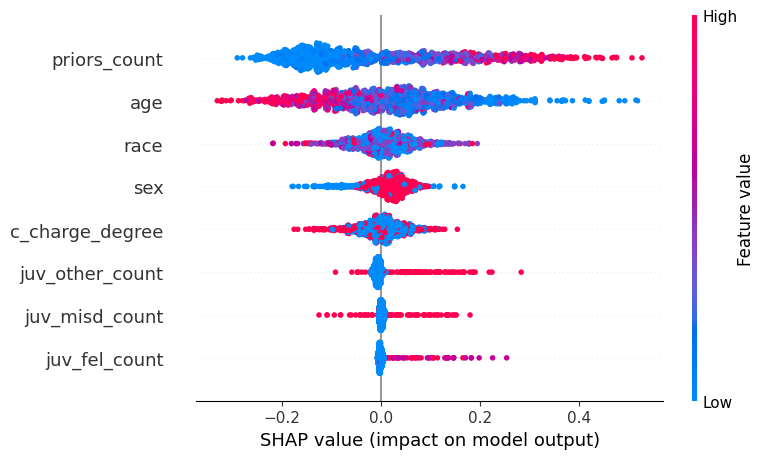

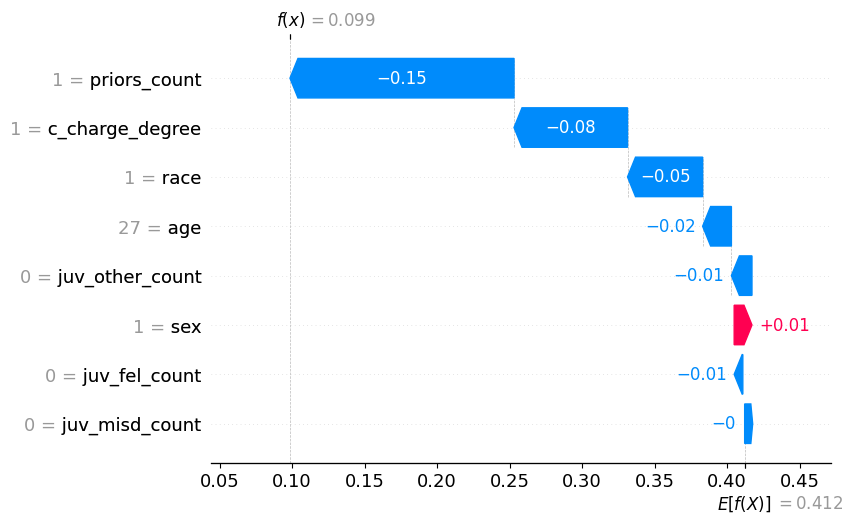

In [4]:
explainer = shap.Explainer(model_compas, X_train)

# global summary
shap_test = explainer(X_test)
shap.summary_plot(shap_test[:,:,1], X_test, feature_names=features)

# explain Malik Johnson
shap_focus = explainer(focus_instance_compas)
shap_class1 = shap_focus[:,:,1]  # select the Recidivism class
shap.plots.waterfall(
    shap.Explanation(
        values=shap_class1[0],
        base_values=shap_focus.base_values[0,1],
        data=focus_instance_compas.values[0],
        feature_names=features
    )
)

The SHAP plots show that Malik Johnson's classification as low risk was primarily driven by the model assigning negative weight to his prior record and felony charge (both of which actually reduced his predicted recidivism score rather than increasing it). While features like age, race, and sex had smaller influences, the strongest downward pushes came from factors that would typically be seen as high-risk in criminological practice. This suggests the model may be underestimating the significance of prior offenses and felony charges, creating the possibility that Malik's risk was misclassified.

### LIME

LIME Explanation:
[('juv_fel_count <= 0.00', -0.11016053454312498), ('0.00 < priors_count <= 2.00', -0.09890050156853941), ('juv_misd_count <= 0.00', -0.06713755564005076), ('juv_other_count <= 0.00', -0.05227710871724525), ('25.00 < age <= 31.00', 0.05175504374985389), ('0.00 < c_charge_degree <= 1.00', -0.030887418067785086), ('0.00 < race <= 2.00', 0.0033246634537481665), ('sex <= 1.00', 0.0)]


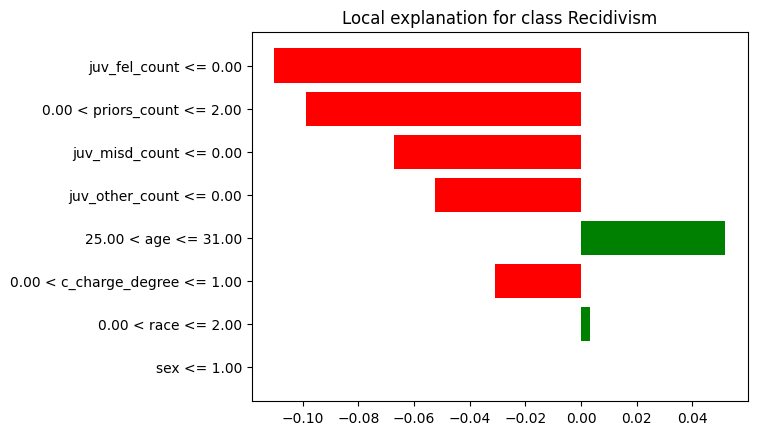

In [5]:
warnings.filterwarnings("ignore")

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=features,
    class_names=['No Recidivism', 'Recidivism'],
    discretize_continuous=True
)

# explain Malik Johnson
lime_exp = lime_explainer.explain_instance(
    data_row=focus_instance_compas.iloc[0],
    predict_fn=model_compas.predict_proba
)

print("LIME Explanation:")
print(lime_exp.as_list())
lime_exp.as_pyplot_figure()
plt.show()

The LIME explanation again indicates that Malik Johnson was classified as low risk because several factors that normally signal concern worked in the opposite direction. His single prior offense and current felony charge were treated as reducing overall risk rather than raising it. The absence of a juvenile record carried the strongest (negative) weight, pushing the prediction away from recidivism. This model discounted prior and felony history while heavily rewarding the lack of juvenile offenses, which may have contributed to an underestimation of Malik's overall risk.